<a href="https://colab.research.google.com/github/goelpravin/practice/blob/master/segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/tensorflow/examples.git
!pip install -U tfds-nightly

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-hhkdluc5
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-hhkdluc5
  Created wheel for tensorflow-examples: filename=tensorflow_examples-4090ac205949af2f7b02d61012db7a66679818fc_-cp36-none-any.whl size=135403 sha256=8bd3e44a4a3938158b84fa3a60d71c602ee54d04364d245d7e7e78f17b9ec3e5
  Stored in directory: /tmp/pip-ephem-wheel-cache-j0adte_h/wheels/83/64/b3/4cfa02dc6f9d16bf7257892c6a7ec602cd7e0ff6ec4d7d714d
Successfully built tensorflow-examples
     |████████████████████████████████| 3.4MB 8.0MB/s 


In [2]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteMGQF2R/oxford_iiit_pet-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteMGQF2R/oxford_iiit_pet-test.tfrecord
Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [46]:
import tensorflow as tf


def getImageMask(datapoint):
  image = tf.image.resize(datapoint['image'], (128, 128))
  mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))
  return tf.expand_dims(image, axis=0), tf.expand_dims(mask, axis=0)



In [48]:
def tfds_imgen(ds, imgen, batch_size):
  for images, labels in ds:
    yield next( imgen.flow(x=images, y=labels, batch_size=batch_size))


In [62]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
train_ds = dataset['train'].map(getImageMask)
test_ds = dataset['test'].map(getImageMask)

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
validation_datagen = ImageDataGenerator(rescale=1/255)
batch_size_training = 128
batch_size_validation = 32
train_generator = tfds_imgen(train_ds.as_numpy_iterator(),train_datagen,batch_size_training)
validation_generator = tfds_imgen(test_ds.as_numpy_iterator(),validation_datagen,batch_size_validation)


In [111]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      #display([tf.squeeze(image[0],axis=0), tf.squeeze(mask[0],axis=0), create_mask(pred_mask)])
      display(image, mask, create_mask(pred_mask))
  else:
    for image, mask in train_ds.take(1):
      img2predict, mask2predict = image, mask
    display([sample_image, sample_mask,
             create_mask(model.predict(img2predict))])
             #create_mask(model.predict(sample_image))])

In [108]:
def create_mask(pred_mask):
  print("pred mask",pred_mask)
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

pred mask [[[[nan nan nan]
   [nan nan nan]
   [nan nan nan]
   ...
   [nan nan nan]
   [nan nan nan]
   [nan nan nan]]

  [[nan nan nan]
   [nan nan nan]
   [nan nan nan]
   ...
   [nan nan nan]
   [nan nan nan]
   [nan nan nan]]

  [[nan nan nan]
   [nan nan nan]
   [nan nan nan]
   ...
   [nan nan nan]
   [nan nan nan]
   [nan nan nan]]

  ...

  [[nan nan nan]
   [nan nan nan]
   [nan nan nan]
   ...
   [nan nan nan]
   [nan nan nan]
   [nan nan nan]]

  [[nan nan nan]
   [nan nan nan]
   [nan nan nan]
   ...
   [nan nan nan]
   [nan nan nan]
   [nan nan nan]]

  [[nan nan nan]
   [nan nan nan]
   [nan nan nan]
   ...
   [nan nan nan]
   [nan nan nan]
   [nan nan nan]]]]
tf.Tensor(
[[[ 5.          3.2478027   3.5043945 ]
  [ 5.477783    4.1274414   3.1784668 ]
  [ 3.532959    4.439209    3.986084  ]
  ...
  [ 2.2563477   0.78759766  1.5219727 ]
  [ 2.1027832   2.1027832   1.171875  ]
  [ 7.          3.          3.09375   ]]

 [[ 3.7524414   4.078125    2.6340332 ]
  [ 3.6677246   3

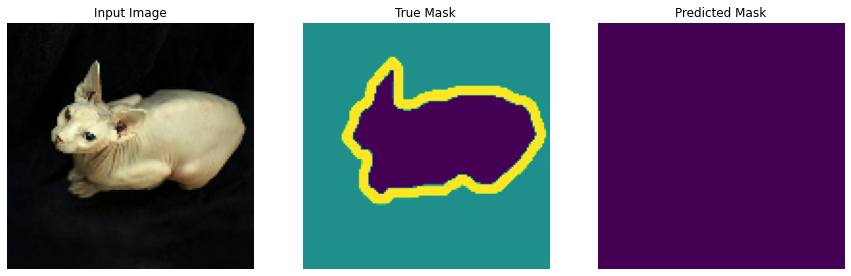

In [112]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    print(display_list[i])

    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()
for image, mask in train_ds.take(1):
  sample_image, sample_mask = tf.squeeze(image,axis=0), tf.squeeze(mask,axis=0)
#display([sample_image, sample_mask])
show_predictions()

In [94]:
from tensorflow_examples.models.pix2pix import pix2pix
OUTPUT_CHANNELS = 3
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False


up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

model = unet_model(OUTPUT_CHANNELS)
print("test")
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


test


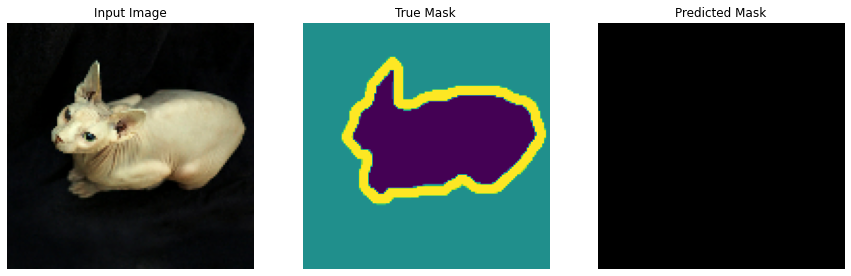


Reached 80% accuracy, so stopping further epochs
29/28 [==============================] - 2s 65ms/step - loss: nan - accuracy: 1.0000 - val_loss: nan - val_accuracy: 1.0000


In [100]:
from IPython.display import clear_output
class myCallback (tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    clear_output(wait=True)
    show_predictions()
    if(logs.get('accuracy')>0.8):
      print("\nReached 80% accuracy, so stopping further epochs")
      self.model.stop_training = True
callbacks = myCallback()


num_training_images = info.splits['train'].num_examples
epoch_steps = num_training_images/batch_size_training

num_testing_images = info.splits['test'].num_examples
validation_steps = num_testing_images/batch_size_validation

history = model.fit(
      train_generator,
      steps_per_epoch=epoch_steps,  
      epochs=10,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=validation_steps,
      callbacks=[callbacks])

In [113]:
show_predictions(test_ds)

pred mask [[[[nan nan nan]
   [nan nan nan]
   [nan nan nan]
   ...
   [nan nan nan]
   [nan nan nan]
   [nan nan nan]]

  [[nan nan nan]
   [nan nan nan]
   [nan nan nan]
   ...
   [nan nan nan]
   [nan nan nan]
   [nan nan nan]]

  [[nan nan nan]
   [nan nan nan]
   [nan nan nan]
   ...
   [nan nan nan]
   [nan nan nan]
   [nan nan nan]]

  ...

  [[nan nan nan]
   [nan nan nan]
   [nan nan nan]
   ...
   [nan nan nan]
   [nan nan nan]
   [nan nan nan]]

  [[nan nan nan]
   [nan nan nan]
   [nan nan nan]
   ...
   [nan nan nan]
   [nan nan nan]
   [nan nan nan]]

  [[nan nan nan]
   [nan nan nan]
   [nan nan nan]
   ...
   [nan nan nan]
   [nan nan nan]
   [nan nan nan]]]]


TypeError: ignored